In [0]:
!pip install pillow
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
seed = 24
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch, lossfuntion):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if lossfunction == 'mse':
          one_hot = torch.zeros_like(output)
          for count in range(output.size(0)):
            one_hot[count, target[count]] = 1.00
          #count = 0
          out_lineal = torch.exp(output)
          
          loss = F.mse_loss(out_lineal, one_hot)
        else:
          loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        #count = count+1
    return losses

In [0]:
def validate(model, device, loader, lossfunction):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    #count = 1

    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if lossfunction == 'mse':
              one_hot = torch.zeros_like(output)
              for count in range(output.size(0)):
                one_hot[count, target[count]] = 1.00
              validation_loss = F.mse_loss(torch.exp(output), one_hot,reduction='sum').item() # sum up batch loss
            else:
              validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    #count = count +1;
    return validation_loss

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size, 
    shuffle=True)

Choose your loss function (Options: NLL (default), MSE (mse), Cross Entropy (cre)) : mse
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.090006
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.089772
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.089449
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.089307
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.089011
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.088577

Validation set: Average loss: 0.0884, Accuracy: 4089/10000 (41%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.088360
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.087955
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.087171
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.087062
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.086349
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.085961

Validation set: Average loss: 0.0855, Accuracy: 5944/10000 (59%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085022
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.084834
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.083096
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0

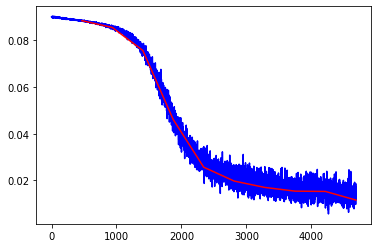

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
valid_losses = []
valid_x = []
num_epochs = 10
lossfunction = input('Choose your loss function (Options: NLL (default), MSE (mse) : ')
for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch, lossfunction)
    train_losses.extend(epoch_losses)
    valid_loss = validate(model, device, valid_loader, lossfunction)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317289
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.566943
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.441314
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.373047
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.275812
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.117694

Validation set: Average loss: 0.1821, Accuracy: 9430/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.134829
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.185549
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.171783
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.106540
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.156709
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.060383

Validation set: Average loss: 0.0931, Accuracy: 9722/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.131102
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.148034
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.096135
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.038033
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.119107
Train Epoch: 3 [51200/60000 (85

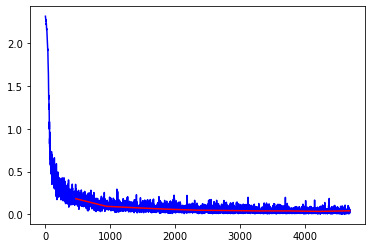

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
valid_losses = []
valid_x = []
num_epochs = 10
lossfunction = 'nll'
for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch, lossfunction)
    train_losses.extend(epoch_losses)
    valid_loss = validate(model, device, valid_loader, lossfunction)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()